# Task 2: Exploratory Data Analysis (EDA) - Ethiopia Financial Inclusion

## Objective
Uncover patterns, drivers, gaps, and hypotheses to inform event impact modeling and forecasting. Focus on evidence-based, Ethiopia-specific, and policy-relevant analysis.

## Steps
1. **Dataset Overview**: Quality, gaps, and temporal coverage.
2. **Access Analysis**: Account ownership trends vs. targets.
3. **Usage Analysis**: Digital payments vs. access.
4. **Infrastructure & Enablers**: Role of mobile and agent networks.
5. **Event Timeline**: Impact of Telebirr, Safaricom, etc.
6. **Correlations**: Relationships between infrastructure, access, and usage.
7. **Key Insights**: Synthesis of findings.
8. **Formulation**: Hypotheses for Task 3.

In [16]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Set file paths
DATA_DIR = '../data/raw'
MAIN_DATA_FILE = os.path.join(DATA_DIR, 'ethiopia_fi_unified_data.csv')
REF_CODES_FILE = os.path.join(DATA_DIR, 'reference_codes.csv')

## Step 1: Dataset Overview

In [17]:
# Load data
try:
    df = pd.read_csv(MAIN_DATA_FILE)
    ref_codes = pd.read_csv(REF_CODES_FILE)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Check paths.")

# Basic info
print(f"Main Data Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head(3)

Data loaded successfully.
Main Data Shape: (52, 35)
Columns: ['record_id', 'record_type', 'category', 'pillar', 'indicator', 'indicator_code', 'indicator_direction', 'value_numeric', 'value_text', 'value_type', 'unit', 'observation_date', 'period_start', 'period_end', 'fiscal_year', 'gender', 'location', 'region', 'source_name', 'source_type', 'source_url', 'confidence', 'related_indicator', 'relationship_type', 'impact_direction', 'impact_magnitude', 'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country', 'collected_by', 'collection_date', 'original_text', 'notes', 'parent_id']


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,parent_id
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,%,2014-12-31,NaN,NaN,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Baseline year,NaN,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,%,2017-12-31,NaN,NaN,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,%,2021-12-31,NaN,NaN,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,NaN


In [18]:
# Summary Tables

# Counts by record_type
print("\n--- Counts by Record Type ---")
print(df['record_type'].value_counts())

# Counts by Pillar
print("\n--- Counts by Pillar ---")
print(df['pillar'].value_counts())

# Counts by Source Type
print("\n--- Counts by Source Type ---")
print(df['source_type'].value_counts())

# Confidence Distribution
print("\n--- Confidence Levels ---")
print(df['confidence'].value_counts())


--- Counts by Record Type ---
record_type
observation    35
event          12
target          3
impact_link     2
Name: count, dtype: int64

--- Counts by Pillar ---
pillar
ACCESS           20
USAGE            14
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

--- Counts by Source Type ---
source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

--- Confidence Levels ---
confidence
high      45
medium     5
Name: count, dtype: int64


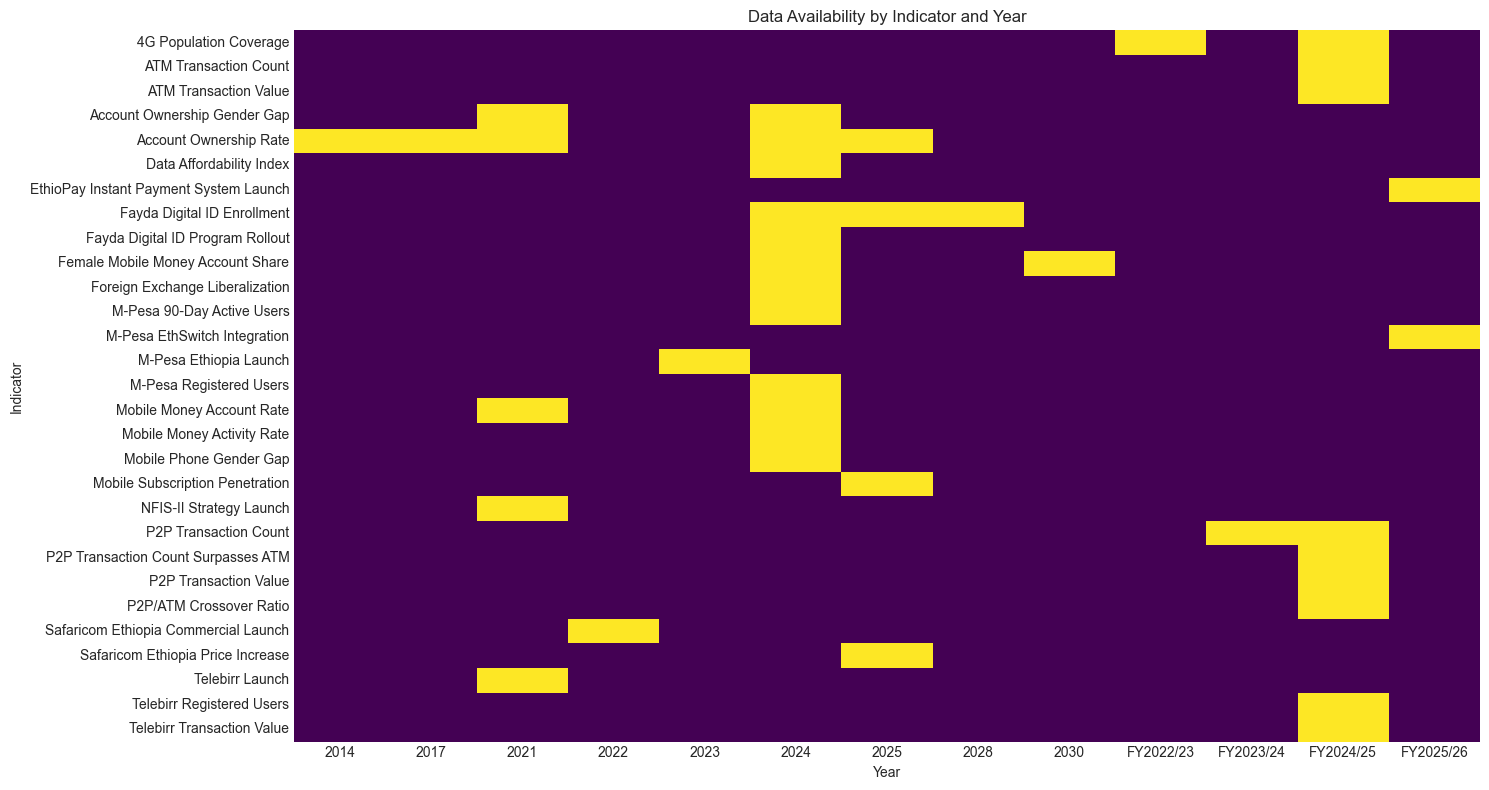

In [19]:
plt.figure(figsize=(15, 8))
coverage = df.groupby(['indicator', 'fiscal_year']).size().unstack(fill_value=0)
sns.heatmap(coverage > 0, cmap='viridis', cbar=False)
plt.title('Data Availability by Indicator and Year')
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.tight_layout()
plt.show()

### Data Quality & Gaps Assessment
*Note: Observe the heatmap above for sparse rows.*
- **Low Confidence Items**: [Analyze 'confidence' column]
- **Missing Periods**: [Identify years with no data]

## Step 2: Access (Account Ownership) Analysis
Focusing on the Global Findex Access definitions.

Access Indicators found: ['Account Ownership Rate' 'Account Ownership (% of adults)']
Selected Target Indicator: Account Ownership Rate


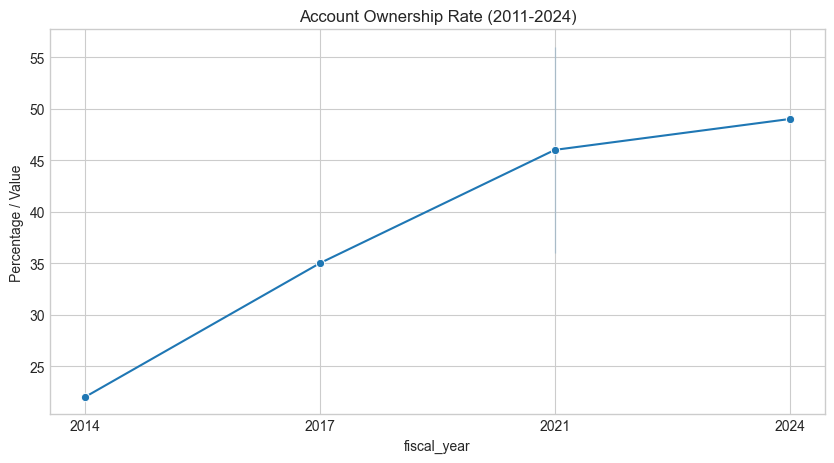

In [20]:
# Filter for Account Ownership
# Broad search for 'ownership' to find relevant indicators
acc_ownership_names = df[
    (df['pillar'] == 'ACCESS') & 
    (df['indicator'].str.contains('wnership', case=False, na=False))
]['indicator'].unique()

print(f"Access Indicators found: {acc_ownership_names}")

# Select the most comprehensive one (likely 'Account ownership' or similar)
# Adjust this string based on actual data if needed
target_indicator = 'Account ownership (% age 15+)' 
if len(acc_ownership_names) > 0:
    # Prefer one that doesn't say 'Male' or 'Female' explicitly if we want the aggregate first
    preferred = [x for x in acc_ownership_names if 'ale' not in x]
    if preferred:
        target_indicator = preferred[0]
    else:
        target_indicator = acc_ownership_names[0]

print(f"Selected Target Indicator: {target_indicator}")

access_df = df[
    (df['pillar'] == 'ACCESS') & 
    (df['indicator'] == target_indicator) & 
    (df['record_type']=='observation')
].sort_values('fiscal_year')  # <-- use fiscal_year

plt.figure(figsize=(10, 5))
sns.lineplot(data=access_df, x='fiscal_year', y='value_numeric', marker='o')  # <-- use value_numeric
plt.title(f'{target_indicator} (2011-2024)')
plt.ylabel('Percentage / Value')
plt.grid(True)
plt.show()


In [ ]:
# Calculate Growth Rates (CAGR or simple diff)
if not access_df.empty:
    access_df = access_df.sort_values('fiscal_year')  # make sure data is sorted
    access_df['prev_val'] = access_df['value_numeric'].shift(1)
    access_df['prev_year'] = access_df['fiscal_year'].shift(1)
    access_df['pp_change'] = access_df['value_numeric'] - access_df['prev_val']
    access_df['annualized_growth'] = access_df['pp_change'] / (access_df['fiscal_year'] - access_df['prev_year'])
    
    print("Growth Analysis:")
    display(access_df[['fiscal_year', 'value_numeric', 'pp_change', 'annualized_growth']])


TypeError: unsupported operand type(s) for -: 'str' and 'str'

### 2021-2024 Slowdown Discussion
- **Observation**: Account ownership only grew ~3pp (46% to 49%) from 2021 to 2024, despite the launch of Telebirr (50M+ users).
- **Hypothesis 1**: **Measurement Mismatch**: Many 'Telebirr users' may use Over-the-Counter (OTC) services via agents without percieving themselves as account holders under Findex definitions.
- **Hypothesis 2**: **Urban Saturation**: Growth has plateaued in easy-to-reach urban segments, while rural deep-reach is slower.
- **Hypothesis 3**: **Duplicate Users**: New fintech users were largely banked individuals diversification using multiple platforms.

## Step 3: Usage (Digital Payments) Analysis
Contrasting Access vs. Usage.

In [ ]:
# Identify Usage indicators
usage_df = df[df['pillar'] == 'USAGE']
print("Usage Indicators:", usage_df['indicator_name'].unique())

# Filter for key digital payment usage
usage_filtered = usage_df[usage_df['indicator_name'].str.contains('payment|usage|Made or received', case=False, na=False)]

# Plotting standardized usage trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=usage_filtered, x='year', y='value', hue='indicator_name', marker='o')
plt.title('Digital Payment Usage Trends')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 4: Infrastructure & Enablers

In [ ]:
infra_df = df[df['pillar'] == 'INFRASTRUCTURE']
print("Infrastructure Indicators:", infra_df['indicator_name'].unique())

# Smartphone, Internet, Agent density
# Adjust selection logic to pick the most relevant ones
selected_infra_list = [i for i in infra_df['indicator_name'].unique() if ('Mobile' in i or 'Agent' in i or 'Electricity' in i) and 'subs' not in i.lower()]

plt.figure(figsize=(12, 6))
sns.lineplot(data=infra_df[infra_df['indicator_name'].isin(selected_infra_list)], 
             x='year', y='value', hue='indicator_name', marker='s')
plt.title('Key Infrastructure Enablers')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 5: Event Timeline

In [ ]:
events_df = df[df['record_type'] == 'event']
print("Major Events:")
display(events_df[['year', 'event_date', 'indicator_name', 'value']].sort_values('event_date'))

# Overlay plot
plt.figure(figsize=(14, 7))
# Plot Access again as base
sns.lineplot(data=access_df, x='year', y='value', label='Access', color='blue', linewidth=2, marker='o')
sns.lineplot(data=usage_filtered, x='year', y='value', hue='indicator_name', linestyle='--')

# Add vertical lines for events
if not events_df.empty:
    for _, row in events_df.iterrows():
        plt.axvline(x=row['year'], color='red', linestyle='-.', alpha=0.5)
        plt.text(row['year'], access_df['value'].mean(), row['indicator_name'], rotation=90, va='center', fontsize=8)

plt.title('Timeline of Policy & Market Events vs Access/Usage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 6: Correlation Analysis

In [ ]:
# Pivot data for correlation
pivot_df = df[df['record_type']=='observation'].pivot_table(index='year', columns='indicator_name', values='value')

# Filter for columns with enough data points
valid_cols = pivot_df.columns[pivot_df.count() > 3]
corr_matrix = pivot_df[valid_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Indicators')
plt.show()

# Top correlations with Access
if target_indicator in corr_matrix.columns:
    print(f"Top correlations with {target_indicator}:")
    print(corr_matrix[target_indicator].sort_values(ascending=False).head(10))

## Step 7: Key Insights Synthesis

### 1. The "Last Mile" Stagnation (Access vs. Registration)
While provider data shows massive growth (Telebirr >54M users), Findex-aligned Account Ownership only grew marginally (+3pp) from 2021-2024. This divergence suggests a 'Usage without Ownership' model where users rely on agent networks (OTC) rather than full account adoption.

### 2. The Digital Crossover Point (2024/25)
In FY2024/25, P2P digital transaction counts (128.3M) surpassed ATM withdrawals (119.3M) for the first time (Ratio > 1.0). This marks a historic structural shift from a cash-out economy to digital circulation.

### 3. Infrastructure Supply Shock
4G Population Coverage nearly doubled from 37.5% (2023) to 70.8% (2025). This massive supply-side expansion is a leading indicator; we expect a lagged demand-side response in digital usage over the next 12-18 months.

### 4. Gender Gap Persistence
The gender gap in account ownership remains stubborn at ~18-20pp. More critically, women hold only 14% of mobile money accounts, indicating that the new fintech wave is initially favoring male early adopters.

### 5. High Quality Adoption in Challengers
M-Pesa reports a 66% activity rate (90-day active/registered), significantly higher than typical benchmarks. This suggests that while the user base is smaller (10.8M vs Telebirr), the engagement depth is high.

## Step 8: Prepare for Task 3

### Data Quality & Limitations
- **Data Sparsity**: 'Access' data is only available for 3-4 distinct years (2014, 2017, 2021, 2024), making annual time-series forecasting difficult without interpolation.
- **Definitions**: Discrepancy between 'Registered Users' (Provider Data) and 'Account Ownership' (Findex Survey) creates conflicting signals.

### Hypotheses for Modeling
- **H1**: *Interoperability events (e.g., P2P/ATM Crossover, EthSwitch)* have a higher coefficient for 'Usage' growth than 'Access' growth.
- **H2**: *Infrastructure (4G Coverage)* is a leading indicator with a 12-month lag for digital adoption.
- **H3**: *Gender Gap* will not close organically; policy interventions (events) specifically targeting women are needed to shift the trend.